# Generate .csv files for CNN

## Imports and Constants

In [38]:
import numpy as np
import pandas as pd

from keras import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

## Utils

In [39]:
def plot_cm(y_true, y_pred, class_names, font_scale=0.8):
    cm = confusion_matrix(y_true, y_pred, normalize='true')    
    fig, ax = plt.subplots(figsize=(24, 20)) 

    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    ax = sns.heatmap(cm, cmap=cmap, annot=False, linewidth=0.01, fmt=".3f", ax=ax)

    plt.ylabel('Actual', fontsize=40)
    plt.xlabel('Predicted', fontsize=40)
    ax.set_xticklabels(class_names, fontsize=24)
    ax.set_yticklabels(class_names, rotation=0, fontsize=24)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=40)
    plt.show()
    
    
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (360 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

In [40]:
def one_hot_encode(encoder, y_train, y_validation, y_test):    
    y_train = y_train.reshape(-1, 1)
    y_validation = y_validation.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_validation = enc.transform(y_validation)
    y_test = enc.transform(y_test)
    
    return y_train, y_validation, y_test


def create_whole_dataset(df_train, df_validation, df_test, encoder, room=None, dist=None):
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values
    X_validation = df_validation.drop(columns=['dist', 'room', 'label']).values
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values
    
    # Create train/test labels
    y_train, y_validation, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_validation['label'].values, df_test['label'].values)
    
    return X_train, X_validation, y_train, X_test, y_validation, y_test

In [41]:
df_train = pd.read_csv('../training_data/azimuth_train_dataset.csv', index_col=[0])
df_validation = pd.read_csv('../training_data/azimuth_validation_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/azimuth_test_dataset.csv', index_col=[0])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit([[label] for label in df_train['label']])
X_train, X_validation, y_train, X_test, y_validation, y_test = create_whole_dataset(df_train, df_validation, df_test, encoder)

In [42]:
# X_ holds (len(df), len(timestep)), y_ hols(len(df), [0..0] of #angle values; 1 when angle occurs)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape,  X_test.shape, y_test.shape

((57593, 21), (57593, 19), (1406, 21), (1406, 19), (2166, 21), (2166, 19))

## CNN

In [43]:
# Fit model
epochs, batch_size, verbose = 10, 64, 1

def create_simple_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features), padding='same'))
    model.add(Flatten())   # 1D array
    model.add(Dense(n_outputs, activation='softmax'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_validation, y_validation))
    
    return model, history

In [44]:
# Fit model
epochs, batch_size, verbose = 25, 64, 1

def create_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features), padding='same'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())   # 1D array
    model.add(Dense(512, activation='linear'))
    model.add(Dense(n_outputs, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_validation, y_validation))
    
    return model, history

In [45]:
model, history = create_model(X_train, y_train)
np.save('../models/history_simple.npy', history.history)

Epoch 1/25
900/900 [==============================] - 7s 7ms/step - loss: 0.6596 - accuracy: 0.7818 - val_loss: 0.6148 - val_accuracy: 0.7817
Epoch 2/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4735 - accuracy: 0.8379 - val_loss: 0.5933 - val_accuracy: 0.7937
Epoch 3/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4537 - accuracy: 0.8436 - val_loss: 0.5788 - val_accuracy: 0.7866
Epoch 4/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4446 - accuracy: 0.8479 - val_loss: 0.5763 - val_accuracy: 0.7888
Epoch 5/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4311 - accuracy: 0.8511 - val_loss: 0.5544 - val_accuracy: 0.7923
Epoch 6/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4289 - accuracy: 0.8528 - val_loss: 0.5522 - val_accuracy: 0.8030
Epoch 7/25
900/900 [==============================] - 6s 7ms/step - loss: 0.4246 - accuracy: 0.8538 - val_loss: 0.5489 - val_accuracy: 0.8080
Epoch 

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 21, 32)            128       
                                                                 
 conv1d_9 (Conv1D)           (None, 21, 32)            3104      
                                                                 
 dropout_4 (Dropout)         (None, 21, 32)            0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 21, 32)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 672)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               344576    
                                                      

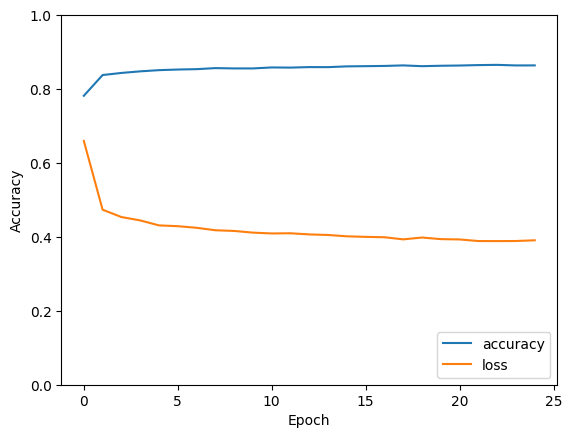

In [47]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [48]:
import keras

keras.utils.plot_model(model,to_file="model.png",show_shapes=True,
                       show_dtype=False,show_layer_names=True,rankdir="TB",
                       expand_nested=True,dpi=96,layer_range=None,
                       show_layer_activations=True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


68/68 [==============================] - 0s 2ms/step


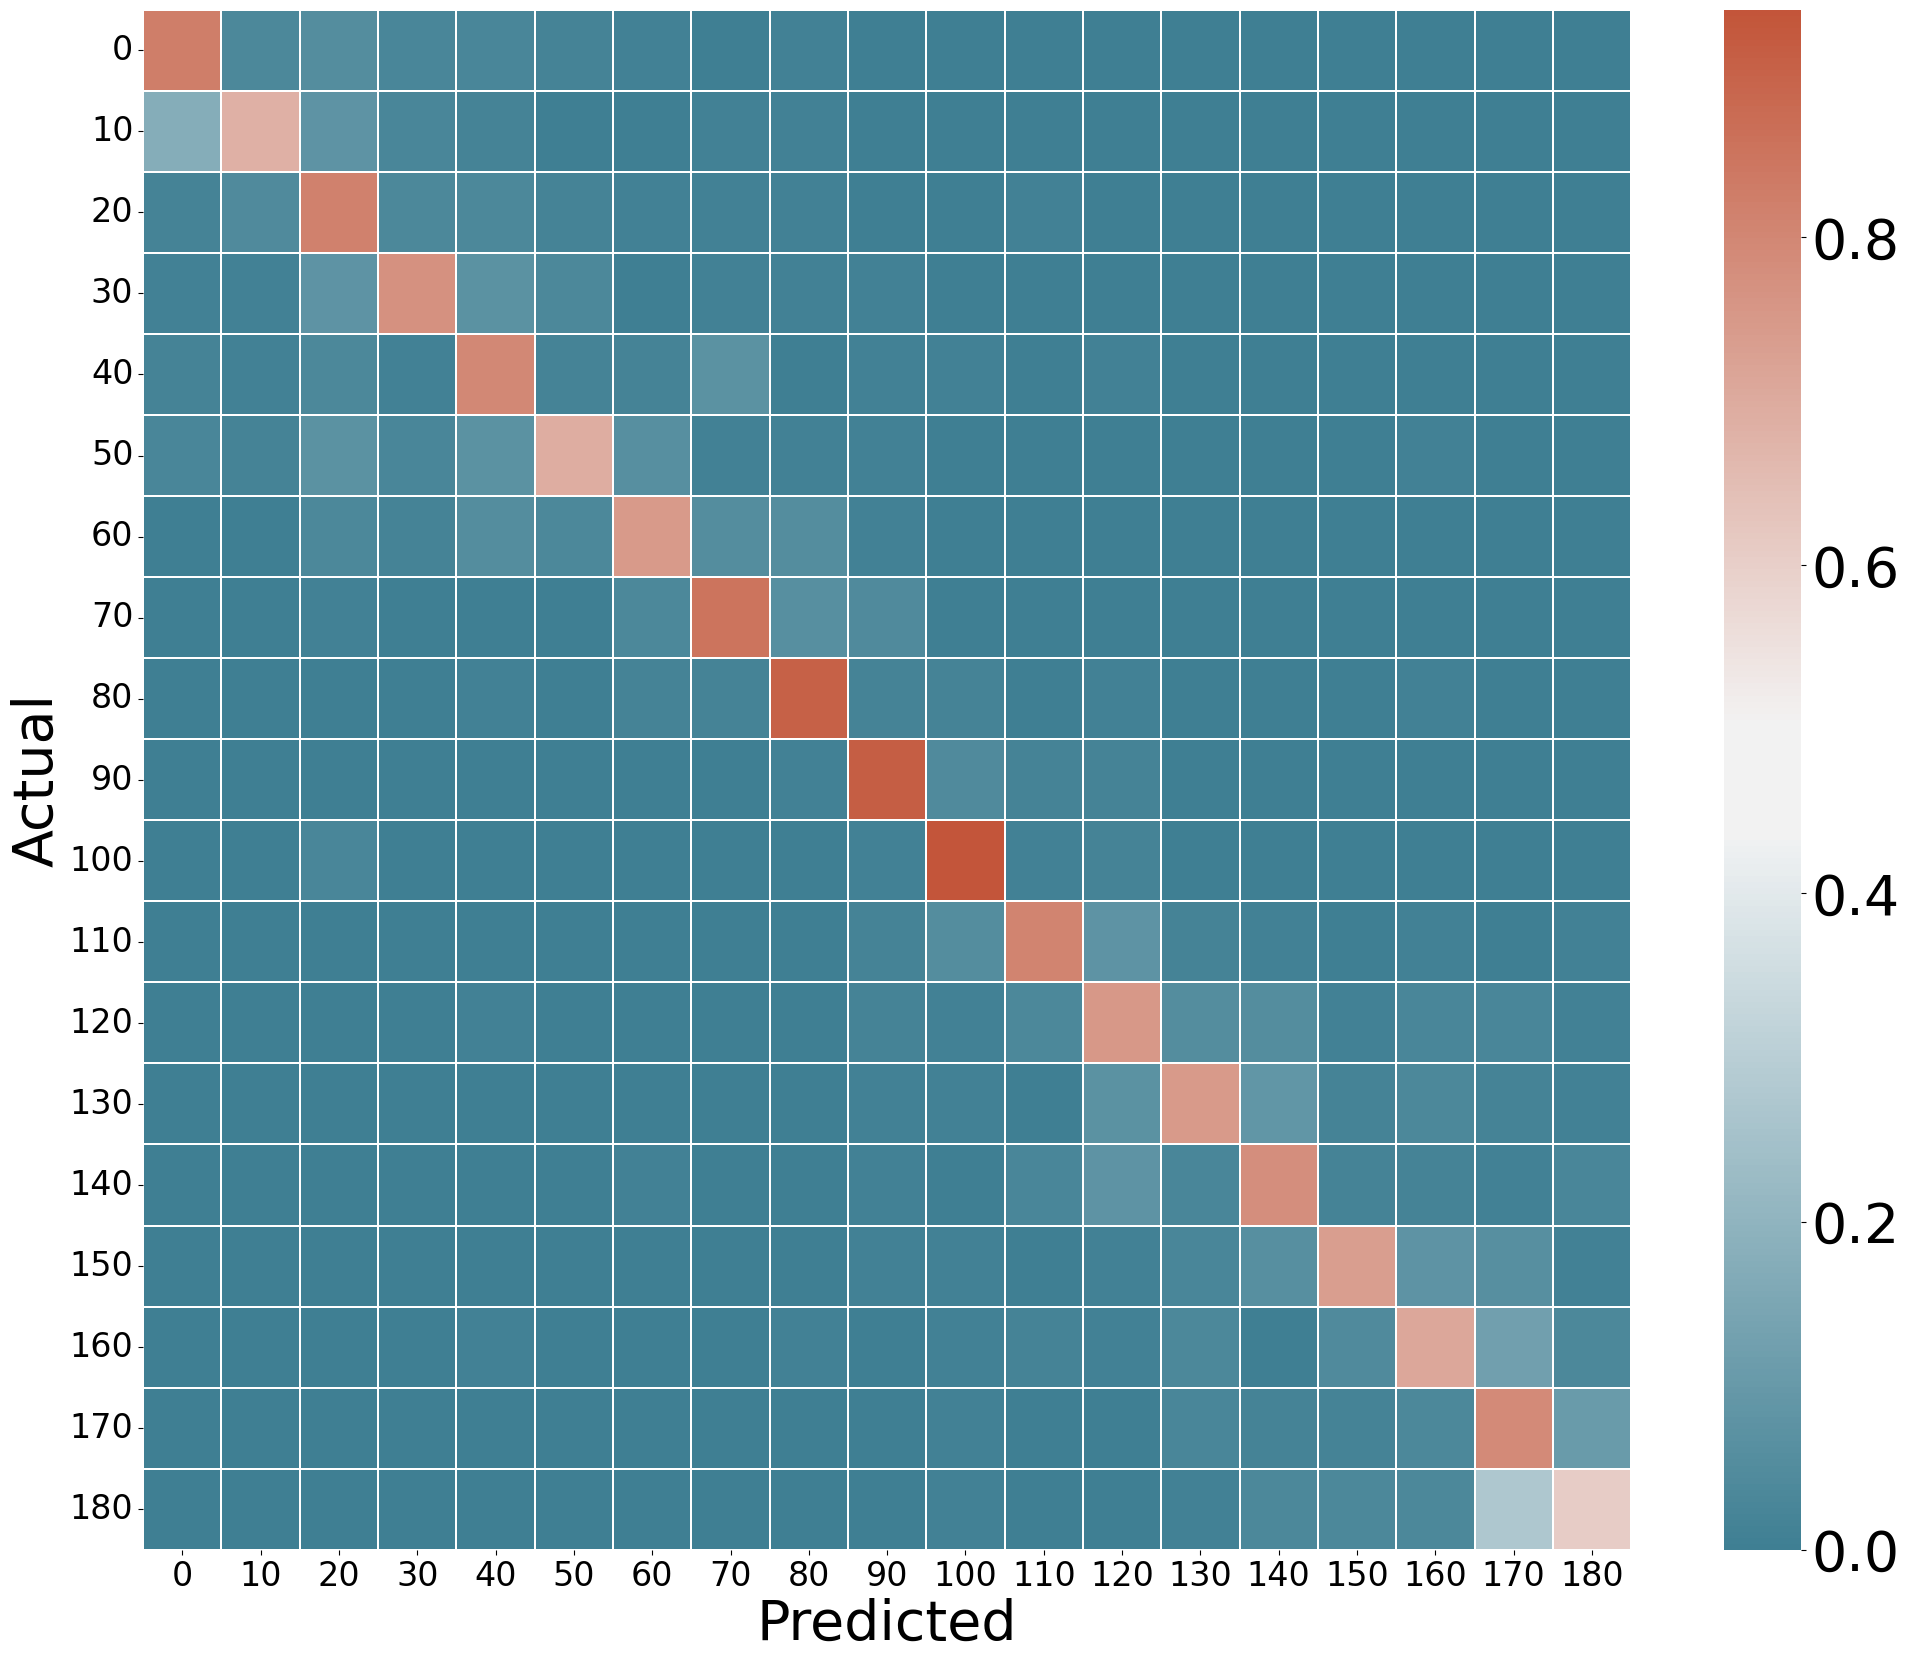

Accuracy: 0.7825
RMSE: 12.827


In [49]:
# Test model
# Get more test sets
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

y_pred_nn = model.predict(X_test)
y_pred_nn = encoder.inverse_transform(y_pred_nn)
y_true_nn = encoder.inverse_transform(y_test)
plot_cm(y_true_nn, y_pred_nn, np.unique(y_true_nn))
print(f'Accuracy: {round(accuracy, 4)}')
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

## Get visualization data

In [50]:
# Chage format of estimations
inter_true = y_true_nn.tolist()
inter_pred = y_pred_nn.tolist()
y_true, y_pred = [],[]

for i in range(len(inter_true)):
    y_true.append(inter_true[i][0])
    y_pred.append(inter_pred[i][0]) 

In [51]:
# Save y_true, y_pred to .csv
data = {"y_true": y_true, "y_pred": y_pred}
df = pd.DataFrame(data)
df.to_csv('../comparison/CNN_spectrum.csv', index=False)

In [52]:
# Create dataset for the three axis graph
df = pd.DataFrame(columns=['y_true', 'y_pred'])

for i in range(len(y_true)):
    if y_true[i] in df['y_true'].values:
        get_current_value = df.loc[df['y_true'] == y_true[i], 'y_pred'].values
        df.loc[df['y_true'] == y_true[i], 'y_pred'] = round(np.average([get_current_value[0], y_pred[i]])/ 5) * 5
    else: 
        df.loc[len(df)] = [y_true[i], y_pred[i]]

df = df.sort_values(by=['y_true'])
df.to_csv('../comparison/CNN_data.csv', index=False)

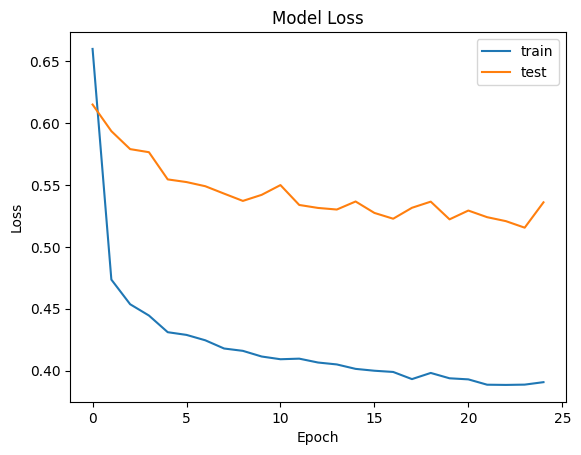

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()